In [1]:
from nanodrivers.visa_drivers.anapico import ANAPICO
from nanodrivers.visa_drivers.SIM928_voltage_source import SIM # as DC
from nanodrivers.visa_drivers.vna import VNA
from nanodrivers.visa_drivers.dc import DC

#math
import numpy as np
from numpy import *
from scipy.optimize import curve_fit

#plotting
import matplotlib.pyplot as plt
import matplotlib

#matlab import
import scipy.io
from scipy.io import savemat
from scipy.optimize import minimize
from scipy.fft import fft, ifft, fftshift, ifftshift


#file_store
import os

#time
import time
from datetime import datetime, timedelta


from ctypes import *
%matplotlib inline

Global_data_adress = r"C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA"
exp_name = 'TWPA_noise_10'
adress = Global_data_adress+'\\'+exp_name
if not os.path.exists(adress):
  os.mkdir(adress)
  print("Folder %s created!" % adress)
else:
  print("Folder %s already exists" % adress)

Folder C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_10 created!


In [2]:
dc = SIM(slot_num=7)
dc.idn()

Connection exist: Stanford_Research_Systems,SIM928,s/n035459,ver2.7



In [3]:
dc.disconnect()

SIM928 is now disconnected from SIM900 mainframe


In [5]:
vna = VNA()
vna.idn()

Connection exist: Rohde-Schwarz,ZNB20-2Port,1311601062102129,3.45



In [10]:
anapico = ANAPICO()
anapico.idn()

Connection exist: AnaPico AG,APMS20G,3C6-0B4F40003-0985,1.0.7



# 1st tone sweep

In [11]:
path = adress +'\\'+ '1st_tone'
if not os.path.exists(path):
  os.mkdir(path)
  print("Folder %s created!" % path)
else:
  print("Folder %s already exists" % path)

Folder C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_10\1st_tone created!


In [12]:
dc.set_volt(0)

New round 0/11 (1.5 V) started at 11:26:22
New round 1/11 (1.55 V) started at 11:26:24
New round 2/11 (1.6 V) started at 11:26:27
New round 3/11 (1.65 V) started at 11:26:29
New round 4/11 (1.7 V) started at 11:26:31
New round 5/11 (1.75 V) started at 11:26:34
New round 6/11 (1.8 V) started at 11:26:36
New round 7/11 (1.85 V) started at 11:26:39
New round 8/11 (1.9 V) started at 11:26:41
New round 9/11 (1.95 V) started at 11:26:44
New round 10/11 (2.0 V) started at 11:26:46
Duration: 0:00:32.042272


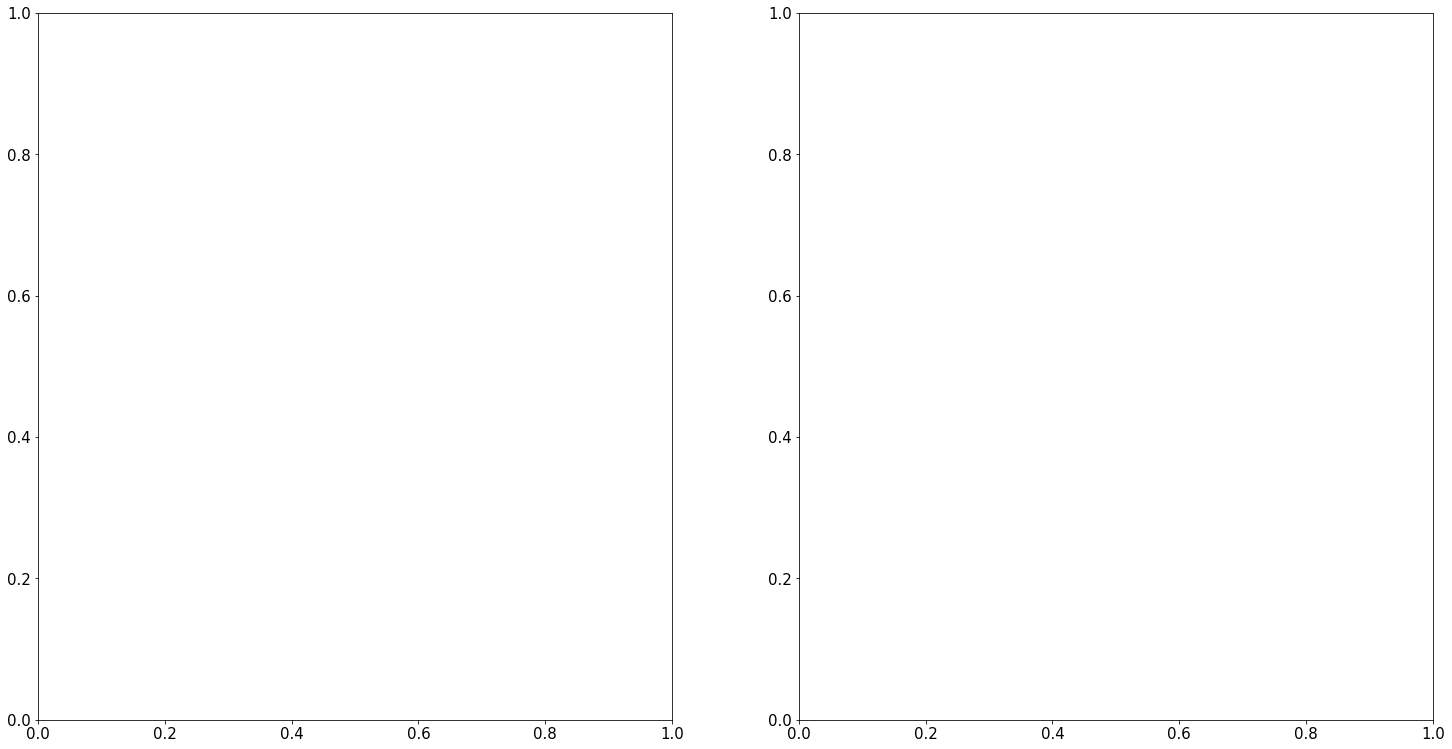

In [13]:
# %matplotlib qt
from IPython.display import display, clear_output
font = {'size'   : 15}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 2, figsize=(25,13))

volts = np.linspace(1.5, 2, 11)
vna.set_band(1000)
vna.set_nop(2001)
vna.set_lin()
vna.set_freq_start_stop(4e9, 8.5e9, vna.get_nop())
vna.set_power(0)
# anapico.set_off(1)

freqs = vna.get_freq()

state = dict()
state['freqs'] = freqs
state['volts'] = volts
# state['vna'] = vna.dump
# state['DC_dev'] = dc.dump
# state['anapico'] = anapico.dump()
state['temp'] = 12
state['VNAPower'] = vna.get_power()

state['Comment'] = 'Measurements after LT30. Lines were changed. TWPA was disconnected during the previous cooldown. With DC filter inside, no capacitor.'

mag_1t = np.ones((len(volts),len(freqs)))*(-40)
pha_1t = np.ones((len(volts),len(freqs)))*(0)

state['mag'] = mag_1t
state['pha'] = pha_1t

start_time = datetime.now()
file = r'1st_tone_test_test'+ start_time.strftime(r'%Y-%m-%d-%H-%M-%S') + '.mat'
file_name = path +'\\' + file

start_time = datetime.now()     
dc.set_volt(volts[0])
dc.set_on()
time.sleep(5)


for i in range(len(volts)):
    
    dc.set_volt(volts[i], sudo=True)
    
#     while dc.get_volt()!= volts[i]:
#         print('Connection problem')
#         time.sleep(5)
#         dc.disconnect()
#         time.sleep(5)
#         dc.disconnect()
#         time.sleep(5)
#         dc = SIM(slot_num=7)
#         a = dc.idn()
#         time.sleep(1)
#         dc.set_volt(volts[i], sudo=True)
    
    curr_time = datetime.now()
    print('New round {}/{} ({} V) started at {}'.format(i, len(volts), volts[i], curr_time.strftime(r'%H:%M:%S')))
                      
    mag_1t[i], pha_1t[i] = vna.get_data()
    
    state['mag'] = mag_1t
    state['pha'] = pha_1t
    
    savemat(file_name, state)



state['mag'] = mag_1t
state['pha'] = pha_1t
savemat(file_name, state)

dc.set_volt(0)   
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Text(0, 0.5, 'Probe frequency, GHz')

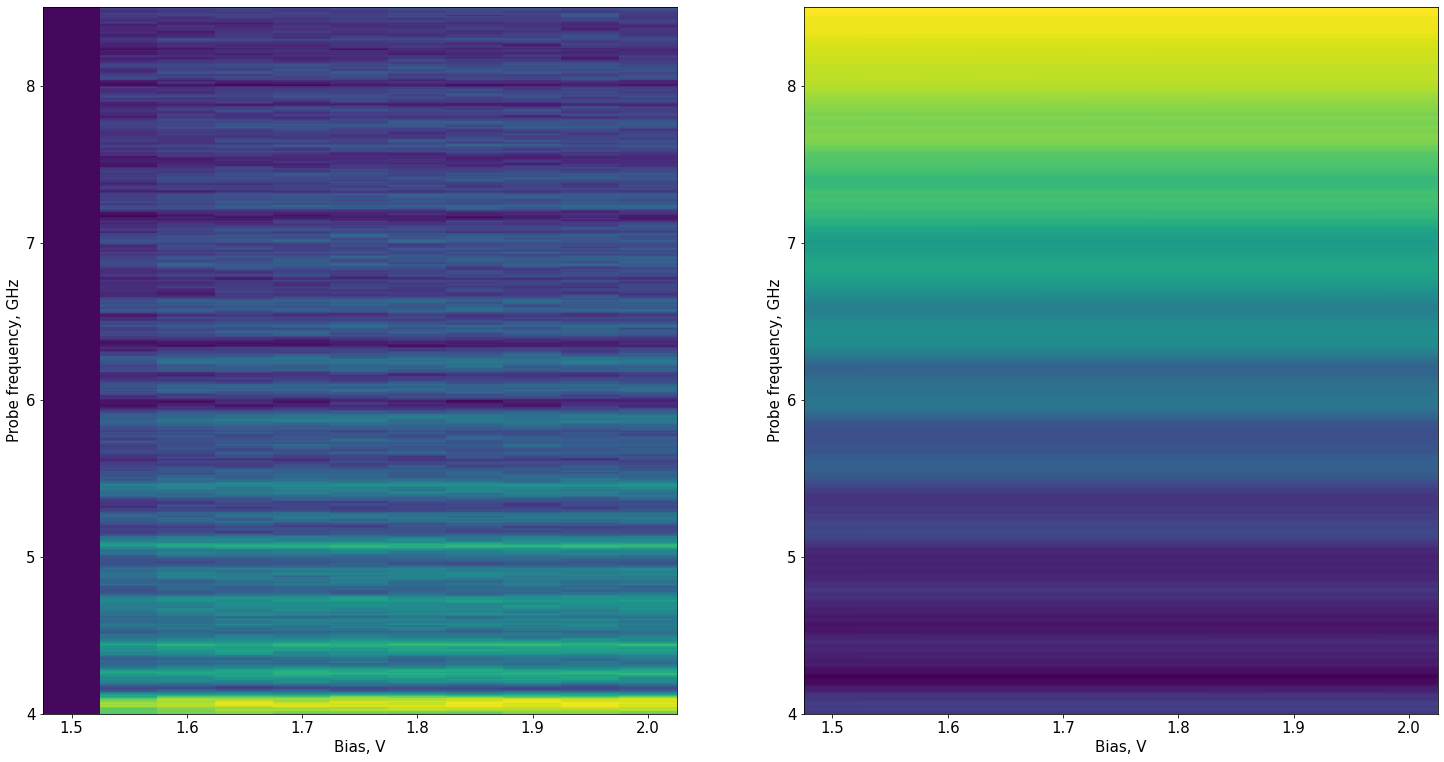

In [14]:
from IPython.display import display, clear_output
font = {'size'   : 15}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 2, figsize=(25,13))

x = volts[:]
y = freqs/1e9
z = mag_1t-mag_1t[0]
zp = pha_1t
c = ax[0].pcolor(x, y,  z[:].T, cmap='viridis')
ax[0].set_xlabel(r'Bias, V')
ax[0].set_ylabel(r'Probe frequency, GHz')

c1 = ax[1].pcolor(x, y, zp[:].T, cmap='viridis')
ax[1].set_xlabel(r'Bias, V')
ax[1].set_ylabel(r'Probe frequency, GHz')
# plt.savefig(path +'\\' + '1st_tone_with_filter_no_cap_full_DC_scale'+ start_time.strftime(r'%Y-%m-%d-%H-%M-%S') + '.png', dpi=150)


In [92]:
%matplotlib qt

In [60]:
(14.5-8.5)/61

0.09836065573770492

In [86]:
anapico.get_status(1)

0.0

In [87]:
anapico.get_freq(1)

8994000000.0

In [82]:
anapico.get_power(1)

7.0

In [85]:
anapico.set_off(1)

In [5]:
# plot


In [6]:
import numpy as np
from numpy import *
from scipy.optimize import curve_fit

#plotting
import matplotlib.pyplot as plt
import matplotlib

#matlab import
import scipy.io
from scipy.io import savemat
from scipy.optimize import minimize
from scipy.fft import fft, ifft, fftshift, ifftshift

#file_store
import os

#time
import time
from datetime import datetime, timedelta


from TWPA_scearch_best_gain import *
def linear_func(x, a, b):
    return a * x + b

def linear_fit(x, y):
    popt, pcov = curve_fit(linear_func, x, y)
    a = popt[0]
    b = popt[1]
    a_err = np.sqrt(pcov[0, 0])
    b_err = np.sqrt(pcov[1, 1])
    return a, b, a_err, b_err

from ctypes import *
%matplotlib inline

Global_data_adress = r"C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA"
exp_name = 'TWPA_noise_9'
adress = Global_data_adress+'\\'+exp_name
if not os.path.exists(adress):
  os.mkdir(adress)
  print("Folder %s created!" % adress)
else:
  print("Folder %s already exists" % adress)


# Stable temperature since 02.06.2025

Folder C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_9 already exists


In [7]:
initial_folder = r'C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_9\1st_tone'
file = "1st_tone_test_with_filter_no_cap_full_DC_scale2025-06-11-18-49-48.mat" 
mat = sio.loadmat(initial_folder+"\\"+file)
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'freqs', 'volts', 'temp', 'VNAPower', 'mag', 'pha'])

In [8]:
freqs = mat['freqs'][0]
volts = mat['volts'][0]
mag = mat['mag']
pha = mat['pha']


In [24]:
import matplotlib.pyplot as plt
import matplotlib

font = {'size': 30}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(1, 2, figsize=(25, 13), sharey = True)

x = volts[:] / 3.937562271670541
y = freqs[10:] / 1e9
z = mag-mag[0]
zp = pha

# Plot magnitude
c = ax[0].pcolor(x, y, z[:, 10:].T, cmap='viridis')
ax[0].set_xlabel(r'$\Phi_{ext}/\Phi_{0}$')
ax[0].set_ylabel(r'Probe frequency, GHz')
fig.colorbar(c, ax=ax[0], label='Magnitude normalized, db')

# Plot phase
c1 = ax[1].pcolor(x, y, zp[:, 10:].T, cmap='viridis')
ax[1].set_xlabel(r'$\Phi_{ext}/\Phi_{0}$')
fig.colorbar(c1, ax=ax[1], label='Phase, rad')

plt.tight_layout()
plt.show()

In [22]:
%matplotlib qt